In [1]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
import pandas as pd
from skimage import filters, measure, morphology, util
from pathlib import Path
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Particle morophology from 2D classes
- Do segementation and region measurment according to the scikit image tutorial: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py

In [2]:
class_avg_fpath = Path("2d_classification_cryosparc\cryosparc_P44_templates_selected.mrc")
assert class_avg_fpath.exists()


px size: 0.24260001182556154 nm
(4, 256, 256) = [  9.70400047 621.05603027 621.05603027] A


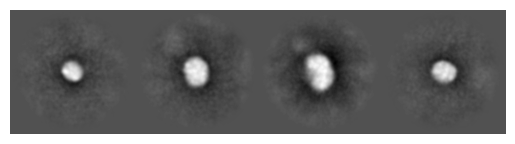

In [8]:
with mrcfile.open(class_avg_fpath) as f:
    class_avgs = f.data
    ANGPIX = f.voxel_size.x
    PXSIZE_NM = ANGPIX * 1e-1
    print(f"px size: {PXSIZE_NM} nm")
print(f"{class_avgs.shape} = {np.array(class_avgs.shape) * ANGPIX} A")

class_avgs_montage = util.montage(class_avgs, grid_shape=(1,4))

plt.imshow(class_avgs_montage, cmap="gray")
plt.axis("off")
plt.show()

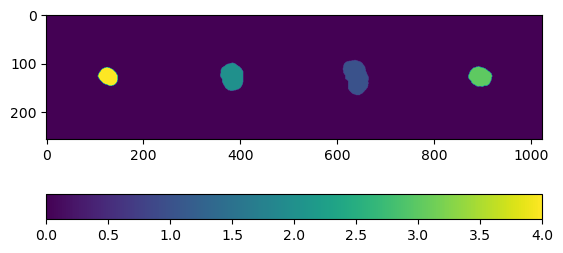

In [4]:
# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(class_avgs_montage)
mask = class_avgs_montage > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask)

plt.imshow(labels)
plt.colorbar(location="bottom")
plt.show()

In [9]:
fig = px.imshow(class_avgs_montage, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, class_avgs_montage)
properties = ["orientation", "axis_minor_length", "axis_major_length"]

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name) * PXSIZE_NM :.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))
    

plotly.io.show(fig)

In [12]:
props_table = measure.regionprops_table(labels, properties=('centroid',
                                                 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
props_df = pd.DataFrame(props_table)
for prop in ["centroid-0", "centroid-1", "axis_major_length", "axis_minor_length"]:
    props_df[prop] *= PXSIZE_NM
props_df

,centroid-0,centroid-1,orientation,axis_major_length,axis_minor_length
0,31.110555,155.217927,0.287621,18.284115,11.616541
1,31.063440,93.138516,0.222091,13.908800,11.346182
2,31.040109,217.372985,1.283718,11.771296,9.635895
3,30.970077,31.075518,0.981044,10.192380,8.349269


In [14]:
props_df.describe()

,centroid-0,centroid-1,orientation,axis_major_length,axis_minor_length
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,31.046045,124.201236,0.693618,13.539147,10.236972
std,0.058510,80.167121,0.522176,3.510817,1.533870
min,30.970077,31.075518,0.222091,10.192380,8.349269
25%,31.022601,77.622766,0.271239,11.376567,9.314238
50%,31.051775,124.178221,0.634333,12.840048,10.491039
75%,31.075219,170.756691,1.056712,15.002629,11.413772
max,31.110555,217.372985,1.283718,18.284115,11.616541
